<p align="center">
  <img height="100" src="https://raw.githubusercontent.com/arguflow/blog/5ef439020707b0e27bf901c8f6b4fb1f487a78d4/apps/frontend/public/assets/horizontal-logo.svg" alt="Arguflow">
</p>

<p align="center">
    <b>Offering a product suite for putting arbitrary models into production semantic search and retrieval-augmented LLM-chat experiences on your company's data</b>
</p>

<p align="center">
<strong><a href="https://docs.arguflow.ai">Documentation</a> • <a href="https://search.arguflow.ai">Competitive Debate Search Demo</a> • <a href="https://chat.arguflow.ai">Competitive Debate Chat Demo</a> • <a href="https://discord.gg/CuJVfgZf54">Discord</a>

</strong>
</p>


# It's time to ditch your specialized vector database for postgresql

The objective behind this notebook was to assess the feasibility of substituting our system's SVD, [Qdrant](https://qdrant.tech/), with [PGVector](https://github.com/pgvector/pgvector) or [lanterndb](https://lantern.dev/) - AKA postgresql + [usearch](https://www.unum.cloud/). Employing an OLT solution like these postgresql focused ones would offer the advantage of utilizing a transactional database with schema and transaction support, thereby eliminating the need for external database joins during diverse search operations.

## Findings

The key takeaway here is that, in contrast to our previous findings with [Clickhouse + usearch](https://blog.arguflow.ai/posts/clickhouse-vs-vector-database-qdrant), these postgres oriented solutions do seem **ready for production**. We will be transitioning our customers with to them instead of [Qdrant](https://qdrant.tech/). However, anticipating the uncertain trajectory of vector store solutions, we're exercising caution and making it easy to switch back to Qdrant or onto another vector db option.

### Replicating our results

1. Download the dataset via [this link](https://drive.proton.me/urls/FED1ABWG70#ItjHZqiPpUao). This is roughly the [DebateSum dataset](https://aclanthology.org/2020.argmining-1.1/), but with some improved parsing loggic and dedup detection as noted on [our docs](https://docs.arguflow.ai).
2. Place the dataset into the same directory as this notebook
3. `docker compose up -d`
4. `cat .env.dist > .env`
4. Run all to duplicate our findings

In [2]:
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http import models

# Load values from the .env file
load_dotenv()

True

In [ ]:
# Get values from the environment variables
qdrant_url = os.getenv("QDRANT_URL")
qdrant_api_key = os.getenv("QDRANT_API_KEY")

# Create the QdrantClient instance
qdrant_client = QdrantClient(
    url=qdrant_url,
    api_key=qdrant_api_key,
)

# qdrant_client.recreate_collection(
#     collection_name="debate_cards",
#     vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE),
# )

In [13]:
import pickle

# Load the dataset from the pickle file
pickle_filename = "dataset.pickle"
with open(pickle_filename, "rb") as pickle_file:
    loaded_dataset = pickle.load(pickle_file)


In [3]:
qdrant_count = qdrant_client.count(
    collection_name="debate_cards",
    exact=True,
)

if qdrant_count.count > 0:
    print("Collection is not empty, exiting")
else:
    # add to qdrant 1k at a time
    for i in range(0, len(loaded_dataset), 1000):
        qdrant_client.upsert(
            collection_name="debate_cards",
            points=models.Batch(
                ids=[item[0] for item in loaded_dataset[i:i+1000]],
                vectors=[item[1] for item in loaded_dataset[i:i+1000]]
            ),
        )

qdrant_client.count(
    collection_name="debate_cards",
    exact=True,
)

Collection is not empty, exiting


CountResult(count=255070)

In [3]:
import psycopg2

pgvector_url = os.getenv("PGVECTOR_URL")
lanterndb_url = os.getenv("LANTERNDB_URL")

pgvector_connection = psycopg2.connect(pgvector_url)
lanterndb_connection = psycopg2.connect(lanterndb_url)

pgvector_cursor = pgvector_connection.cursor()
lanterndb_cursor = lanterndb_connection.cursor()

In [5]:
lanterndb_cursor.execute("CREATE EXTENSION lantern;")
lanterndb_cursor.execute("set enable_seqscan = false;")
lanterndb_connection.commit()

pgvector_cursor.execute("CREATE EXTENSION vector;")
pgvector_cursor.execute("set enable_seqscan = false;")
pgvector_connection.commit()

In [4]:
m_ef_pairs = [(8, 32), (16, 64), (32, 128), (40, 160)]

In [9]:
# 94mins

# for m, ef in m_ef_pairs:
#     delete_table_query = f"DROP TABLE IF EXISTS qdrant_vectors_{m}_{ef};"
#     pgvector_cursor.execute(delete_table_query)
#     pgvector_connection.commit()
#     lanterndb_cursor.execute(delete_table_query)
#     lanterndb_connection.commit()

#     pgvector_create_table_query = f"""
#         CREATE TABLE qdrant_vectors_{m}_{ef} (
#             point_id TEXT PRIMARY KEY,
#             embedding vector(1536)
#         );
#     """
#     pgvector_cursor.execute(pgvector_create_table_query)
#     pgvector_connection.commit()

#     lantern_create_table_query = f"""
#         CREATE TABLE qdrant_vectors_{m}_{ef} (
#             point_id TEXT PRIMARY KEY,
#             embedding real[1536]
#         );
#     """
#     lanterndb_cursor.execute(lantern_create_table_query)
#     lanterndb_connection.commit()

#     if (m, ef) == m_ef_pairs[0]:
#         offset = ""
#         while offset is not None:
#             scroll_result = qdrant_client.scroll(
#                 collection_name="debate_cards",
#                 limit=1,
#                 with_vectors=True,
#                 offset=(offset if offset else None),
#             )

#             offset = scroll_result[1]

#             if scroll_result[0]:  # Check if there are points to insert
#                 insert_found_points_query = f"""
#                     INSERT INTO qdrant_vectors_{m}_{ef} (point_id, embedding)
#                     VALUES
#                 """

#                 values = []
#                 for point in scroll_result[0]:
#                     values.append((point.id, point.vector))

#                 placeholders = ",".join(["(%s, %s)"] * len(values))
#                 insert_found_points_query += placeholders

#                 pgvector_cursor.execute(
#                     insert_found_points_query,
#                     [item for sublist in values for item in sublist],
#                 )
#                 pgvector_connection.commit()
#                 lanterndb_cursor.execute(
#                     insert_found_points_query,
#                     [item for sublist in values for item in sublist],
#                 )
#                 lanterndb_connection.commit()
            
#         continue
    
#     copy_first_m_ef_query = f"""
#         INSERT INTO qdrant_vectors_{m}_{ef}
#         SELECT * FROM qdrant_vectors_{m_ef_pairs[0][0]}_{m_ef_pairs[0][1]};
#     """
#     pgvector_cursor.execute(copy_first_m_ef_query)
#     pgvector_connection.commit()
#     lanterndb_cursor.execute(copy_first_m_ef_query)
#     lanterndb_connection.commit()

        


In [5]:
# create indices
for m, ef in m_ef_pairs:
    pgvector_hnsw_query = f"""
        CREATE INDEX ON qdrant_vectors_{m}_{ef} USING hnsw (embedding vector_cosine_ops) WITH (m = {m}, ef_construction = {ef});
    """
    pgvector_cursor.execute(pgvector_hnsw_query)
    pgvector_connection.commit()

    lantern_hnsw_query = f"""
        CREATE INDEX ON qdrant_vectors_{m}_{ef} USING hnsw (embedding dist_cos_ops) WITH (M={m}, ef_construction={ef}, ef={100}, dim=1536);
    """
    lanterndb_cursor.execute(lantern_hnsw_query)
    lanterndb_connection.commit()



In [12]:
scroll_result = qdrant_client.scroll(
    collection_name="debate_cards",
    limit=100,
    with_vectors=True,
)

first_100_qdrant_vectors = [point.vector for point in scroll_result[0]]

In [57]:
for m, ef in m_ef_pairs:
    index_query = f"""
    SELECT indexname
    FROM pg_indexes
    WHERE tablename = 'qdrant_vectors_{m}_{ef}';
    """
    pgvector_cursor.execute(index_query)
    pgvector_index_names = pgvector_cursor.fetchall()
    print("pgvector indices:", pgvector_index_names)

    lanterndb_cursor.execute(index_query)
    lanterndb_index_names = lanterndb_cursor.fetchall()
    print("lanterndb indices:", lanterndb_index_names)

Indices on qdrant_vectors table:
qdrant_vectors_pkey
qdrant_vectors_embedding_idx
qdrant_vectors_embedding_idx1


In [76]:
first_vector = first_100_qdrant_vectors[0]


pg_cosine_similarity_query = f"""
        SELECT
            point_id,
            1 - (embedding <=> '{first_vector}') AS cosine_similarity
        FROM qdrant_vectors
        ORDER BY embedding <=> '{first_vector}'
        LIMIT 10;
        """

# explain the query
cursor.execute("EXPLAIN ANALYZE" + pg_cosine_similarity_query)
pg_cosine_similarity_explain_result = cursor.fetchall()

cursor.execute(pg_cosine_similarity_query)
pg_results = pg_cosine_similarity_result = cursor.fetchall()
connection.commit()

pg_results

[('00005fed-cfc0-4845-b863-b71550463e24', 1.0),
 ('180ddd7a-a0af-4c3e-bec5-98fc8cd6d589', 0.9155548760626053),
 ('03f07aec-4816-49da-b886-c4fedb05d149', 0.9136285391739514),
 ('6c758916-a2df-4d07-af21-b25f416cbeea', 0.9086524953064392),
 ('3ee155fa-726f-431d-9f9d-30603b9ab1da', 0.9073011125082691),
 ('81b834a8-9b0b-48b0-9b49-9f83879be1e1', 0.9071983320240182),
 ('8f27634e-6a20-474e-b627-8529d475b63e', 0.9068747869879326),
 ('be4d6633-d730-435c-a66b-8b97275bb2b7', 0.9066022316806834),
 ('561ae8a9-af13-4a75-a49f-ce5c38c442ce', 0.9061500709801716),
 ('6af30e7e-4b4a-46f8-a5ac-27c502367b90', 0.9054446389476126)]

In [77]:
import numpy as np
import timeit

qdrant_search_times = []
pg_results_dict = {}
for m, ef in m_ef_pairs:
    pg_results_dict[(m, ef)] = {}
    pg_results_dict[(m, ef)]["pgvector"] = []
    pg_results_dict[(m, ef)]["lanterndb"] = []


for m, ef in m_ef_pairs:
    for i in range(100):
        query_vector = np.random.rand(1536).astype(np.float32).tolist()
        lanterndb_query_vector = str(query_vector).replace("[", "{").replace("]", "}")

        pgvector_cosine_similarity_query = f"""
        SELECT
            point_id,
            1 - (embedding <=> '{query_vector}') AS cosine_similarity
        FROM qdrant_vectors
        ORDER BY embedding <=> '{query_vector}'
        LIMIT 10;
        """

        lanterndb_consine_similarity_query = f"""
        SELECT
            point_id,
            1 - cos_dist(embedding, '{lanterndb_query_vector}') AS cosine_similarity
            FROM qdrant_vectors
        ORDER BY embedding <-> '{lanterndb_query_vector}'
        LIMIT 10;
        """

        def query_pgvector():
            pgvector_cursor.execute(pgvector_cosine_similarity_query)
            pgvector_cursor.fetchall()
            pgvector_connection.commit()
        
        def query_lanterndb():
            lanterndb_cursor.execute(lanterndb_consine_similarity_query)
            lanterndb_cursor.fetchall()
            lanterndb_connection.commit()

        pgvector_time = timeit.timeit(query_pgvector, number=1)
        lanterndb_time = timeit.timeit(query_lanterndb, number=1)
        pg_results_dict[(m, ef)]["pgvector"].append(pgvector_time)
        pg_results_dict[(m, ef)]["lanterndb"].append(lanterndb_time)

        qdrant_search_times.append(timeit.timeit(lambda: qdrant_client.search(collection_name="debate_cards", query_vector=query_vector, limit=10, search_params={"exact": True}), number=1))

    

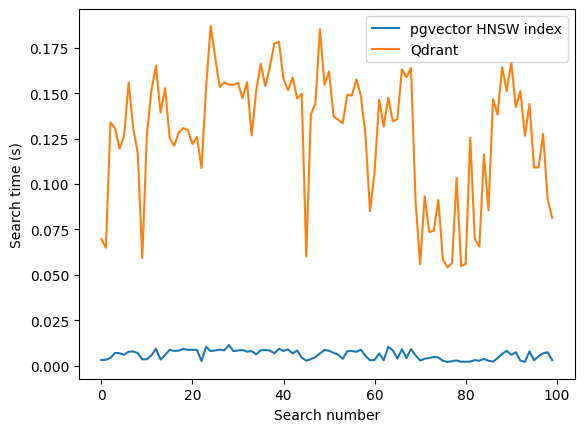

In [78]:
import matplotlib.pyplot as plt

for m, ef in m_ef_pairs:
    plt.plot(pg_results_dict[(m, ef)]["pgvector"], label=f"pgvector HNSW (m={m}, ef={ef})")
    plt.plot(pg_results_dict[(m, ef)]["lanterndb"], label=f"lanterndb HNSW (m={m}, ef={ef})")

plt.plot(qdrant_search_times, label="qdrant HNSW")

plt.xlabel("Search number")
plt.ylabel("Search time (s)")
plt.legend()
plt.show()

In [79]:
for m, ef in m_ef_pairs:
    print(f"m={m}, ef={ef}")
    print(f"pgvector avg search time: {np.mean(pg_results_dict[(m, ef)]['pgvector'])}s")
    print(f"pgvector max search time: {np.max(pg_results_dict[(m, ef)]['pgvector'])}s")
    print(f"pgvector min search time: {np.min(pg_results_dict[(m, ef)]['pgvector'])}s")

    print(f"lanterndb avg search time: {np.mean(pg_results_dict[(m, ef)]['lanterndb'])}s")
    print(f"lanterndb max search time: {np.max(pg_results_dict[(m, ef)]['lanterndb'])}s")
    print(f"lanterndb min search time: {np.min(pg_results_dict[(m, ef)]['lanterndb'])}s")

[qdrant_avg_search_time, qdrant_max_search_time, qdrant_min_search_time] = [np.mean(qdrant_search_times), np.max(qdrant_search_times), np.min(qdrant_search_times)]
print(f"Qdrant avg search time: {qdrant_avg_search_time}s")
print(f"Qdrant max search time: {qdrant_max_search_time}s")
print(f"Qdrant min search time: {qdrant_min_search_time}s")

Pgvector HNSW index avg search time: 0.006089581510059361s
Pgvector HNSW index max search time: 0.01139762300226721s
Pgvector HNSW index min search time: 0.002103237999108387s
Qdrant avg search time: 0.12838763809992088s
Qdrant max search time: 0.1870610490004765s
Qdrant min search time: 0.054102101999887964s


In [81]:
pg_results_dict = {}
for m, ef in m_ef_pairs:
    pg_results_dict[(m, ef)] = {}
    pg_results_dict[(m, ef)]["pgvector"] = []
    pg_results_dict[(m, ef)]["lanterndb"] = []

qdrant_results = []

for m, ef in m_ef_pairs:
    for i in range(100):
        query_vector = np.random.rand(1536).astype(np.float32).tolist()
        lanterndb_query_vector = str(query_vector).replace("[", "{").replace("]", "}")

        pgvector_cosine_similarity_query = f"""
        SELECT
            point_id,
            1 - (embedding <=> '{query_vector}') AS cosine_similarity
        FROM qdrant_vectors
        ORDER BY embedding <=> '{query_vector}'
        LIMIT 10;
        """

        lanterndb_consine_similarity_query = f"""
        SELECT
            point_id,
            1 - cos_dist(embedding, '{lanterndb_query_vector}') AS cosine_similarity
        FROM qdrant_vectors
        ORDER BY embedding <-> '{lanterndb_query_vector}'
        LIMIT 10;
        """

        def query_pgvector():
            pgvector_cursor.execute(pgvector_cosine_similarity_query)
            pgvector_results = pgvector_cursor.fetchall()
            pgvector_connection.commit()
            return pgvector_results
        
        def query_lanterndb():
            lanterndb_cursor.execute(lanterndb_consine_similarity_query)
            lantern_results = lanterndb_cursor.fetchall()
            lanterndb_connection.commit()
            return lantern_results

        pgvector_results = query_pgvector()
        pg_results_dict[(m, ef)]["pgvector"].append(pgvector_results)
        lanterndb_results = query_lanterndb()
        pg_results_dict[(m, ef)]["lanterndb"].append(lanterndb_results)

        qdrant_results_temp = qdrant_client.search(collection_name="debate_cards", query_vector=query_vector, limit=10, with_vectors=False, search_params={"exact": True})
        qdrant_ids = [result.id for result in qdrant_results_temp]
        qdrant_results.append(qdrant_ids)

In [82]:
for m, ef in m_ef_pairs:
    pgvector_hnsw_result_shifts = []

    qdrant_result_idx = 0
    for top_10 in qdrant_results:
        top_10_idx = 0
        for item in top_10:
            if item in pg_results_dict[(m, ef)]["pgvector"][qdrant_result_idx]:
                index_of_item = pg_results_dict[(m, ef)]["pgvector"][qdrant_result_idx].index(item)
                pgvector_hnsw_result_shifts.append(abs(index_of_item - top_10_idx))
            else:
                pgvector_hnsw_result_shifts.append(100)
            top_10_idx += 1
        qdrant_result_idx += 1

    print(f"m={m}, ef={ef}")
    print(f"Pgvector HNSW index avg shift: {np.mean(pgvector_hnsw_result_shifts)}")
    print(f"Pgvector HNSW index max shift: {np.max(pgvector_hnsw_result_shifts)}")
    print(f"Pgvector HNSW index min shift: {np.min(pgvector_hnsw_result_shifts)}")
    print(f"Pgvector HNSW index std shift: {np.std(pgvector_hnsw_result_shifts)}")

for m, ef in m_ef_pairs:
    lanterdb_result_shifts = []

    qdrant_result_idx = 0
    for top_10 in qdrant_results:
        top_10_idx = 0
        for item in top_10:
            if item in pg_results_dict[(m, ef)]["lanterndb"][qdrant_result_idx]:
                index_of_item = pg_results_dict[(m, ef)]["lanterndb"][qdrant_result_idx].index(item)
                lanterdb_result_shifts.append(abs(index_of_item - top_10_idx))
            else:
                lanterdb_result_shifts.append(100)
            top_10_idx += 1
        qdrant_result_idx += 1

    print(f"m={m}, ef={ef}")
    print(f"Lanterndb HNSW index avg shift: {np.mean(lanterdb_result_shifts)}")
    print(f"Lanterndb HNSW index max shift: {np.max(lanterdb_result_shifts)}")
    print(f"Lanterndb HNSW index min shift: {np.min(lanterdb_result_shifts)}")
    print(f"Lanterndb HNSW index std shift: {np.std(lanterdb_result_shifts)}")

Pgvector HNSW index avg shift: 99.0
Pgvector HNSW index max shift: 100
Pgvector HNSW index min shift: 0
Pgvector HNSW index std shift: 9.9498743710662
